In [2]:
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import numpy as np
import os
from shapely.geometry import Polygon, mapping
from rasterio.mask import mask
# a package created for this class that will be discussed later in this lesson
import earthpy as et
import earthpy.spatial as es
# plot inline in the notebook
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style('onedork')
sns.set()
plt.ion()

ImportError: libpoppler.so.71: cannot open shared object file: No such file or directory

In [52]:
sjer_dtm_path = 'data/tut/california/neon-soap-site/2013/lidar/SOAP_lidarDTM.tif'
sjer_dsm_path = "data/tut/california/neon-soap-site/2013/lidar/SOAP_lidarDSM.tif"
# open raster data
# lidar_dem = rio.open(sjer_dtm_path)
with rio.open(sjer_dtm_path) as src:
    dtm = src.read(masked=True, indexes = 1)
    print(data.shape)
    dtm_extent = rio.plot.plotting_extent(src)
print(dtm_extent)

with rio.open(sjer_dsm_path) as src:
    dsm = src.read(masked=True, indexes = 1)
    print(data.shape)
    dsm_meta = src.profile
    print(dsm_meta)
    dsm_extent = rio.plot.plotting_extent(src)
print(dsm_extent)
# optional - view spatial extent
# lidar_dem.bounds
# BoundingBox(left=296906.0, bottom=4100038.0, right=300198.0, top=4101554.0)

(5059, 4296)
(296906.0, 300198.0, 4100038.0, 4101554.0)
(5059, 4296)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3292, 'height': 1516, 'count': 1, 'crs': CRS({'init': 'epsg:32611'}), 'transform': (296906.0, 1.0, 0.0, 4101554.0, 0.0, -1.0), 'affine': Affine(1.0, 0.0, 296906.0,
       0.0, -1.0, 4101554.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
(296906.0, 300198.0, 4100038.0, 4101554.0)


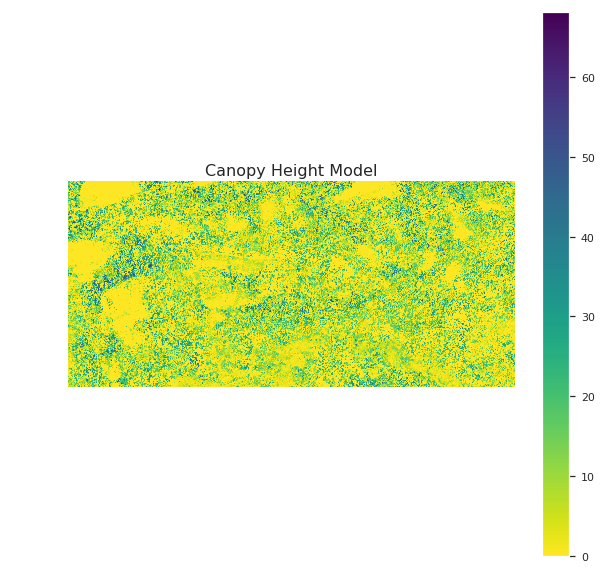

In [32]:
chm = dsm - dtm
fig, axis = plt.subplots(figsize=(10, 10))
lidar_plot = axis.imshow(chm, cmap='viridis_r', extent = dtm_extent)
axis.set_title("Canopy Height Model",
             fontsize = 16)
cbar = plt.colorbar(lidar_plot)
axis.set_axis_off();

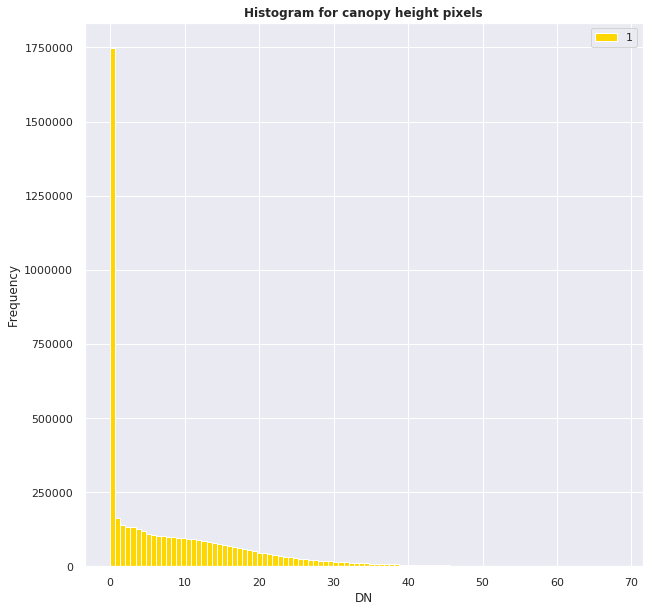

In [41]:
fig, axis = plt.subplots(figsize = (10, 10))
show_hist(chm, bins=100, title = 'Histogram for canopy height pixels')

In [42]:
print("min height recorded = ", chm.min())
print("max height recorded = ", chm.max())

min height recorded =  0.0
max height recorded =  68.119995


## Now let's add colorbreaks

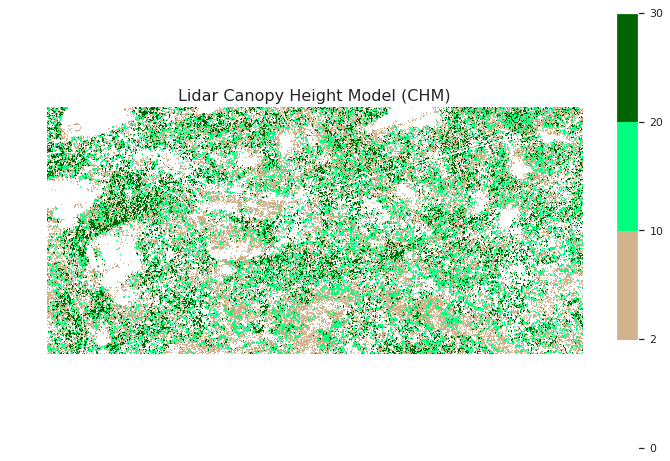

In [50]:
# Define the colors you want
from matplotlib.colors import ListedColormap
import matplotlib
cmap = ListedColormap(["white", "tan", "springgreen", "darkgreen"])

# Define a normalization from values -> colors
norm = matplotlib.colors.BoundaryNorm([0, 2, 10, 20, 30], 5)
fig, ax = plt.subplots(figsize=(12, 8))
chm_plot = ax.imshow(chm, 
                     cmap=cmap,
                     norm=norm)
ax.set_title("Lidar Canopy Height Model (CHM)", fontsize=16)
plt.colorbar(chm_plot)
ax.set_axis_off();

In [64]:
with rio.open('data/outputs/SOAP_lidarCHM.tiff', 'w', **dsm_meta) as fp:
    fp.write(chm,1)

/home/armaan/anaconda3/envs/_py36/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


# Working with vector data

In [79]:
import geopandas as gpd
sjer_plot_locations = gpd.read_file('data/tut/california/neon-sjer-site/vector_data/SJER_plot_centroids.shp')
sjer_crop = gpd.read_file('data/tut/california/neon-sjer-site/vector_data/SJER_crop.shp')
sjer_road = gpd.read_file('data/tut/california/madera-county-roads/tl_2013_06039_roads.shp')
# print(type(sjer_plot_locations))
# print(sjer_plot_locations.total_bounds)
# print(sjer_plot_locations.crs)
print(sjer_plot_locations.shape)
print(sjer_road.shape)
print(sjer_crop.shape)
sjer_plot_locations.head(2)

(18, 6)
(9640, 5)
(1, 2)


,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,POINT (255852.376 4111567.818)
1,SJER112,center,4111298.971,257406.967,trees,POINT (257406.967 4111298.971)


In [80]:
sjer_road.head(2)

,LINEARID,FULLNAME,RTTYP,MTFCC,geometry
0,110454239066,N 14th St,M,S1400,"LINESTRING (-120.272267 37.116151, -120.27244 ..."
1,110454239052,N 11th St,M,S1400,"LINESTRING (-120.267877 37.116672, -120.268072..."


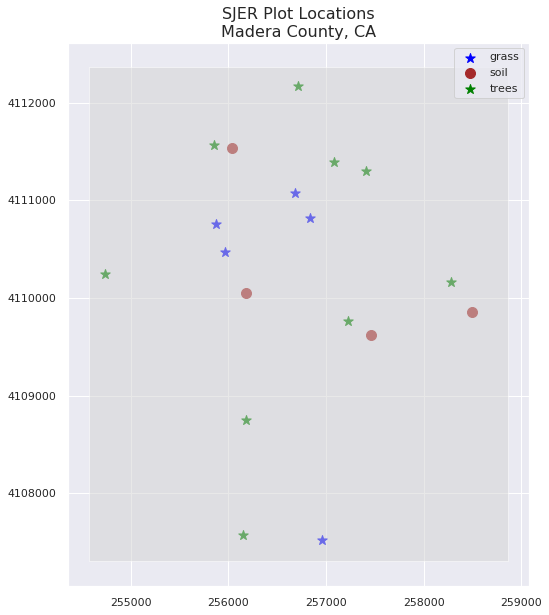

In [92]:
plot_attrs = {'grass': ['blue', '*'], 
               'soil': ['brown','o'],
               'trees': ['green','*']}
fig, axis = plt.subplots(figsize = (10,10))
for ctype, data in sjer_plot_locations.groupby('plot_type'):
    data.plot(color=plot_attrs[ctype][0], 
              label = ctype,
              ax = axis,
              markersize=100,
             marker = plot_attrs[ctype][1],  
)
# sjer_plot_locations.plot(column = 'plot_type', legend = True, ax=axis)
sjer_crop.plot(color = 'lightgrey', ax=axis, alpha=0.5)
axis.legend()
axis.set_title('SJER Plot Locations\nMadera County, CA', fontsize=16);

# working with different CRS:
* CRS (Coordinate reference system) is optimized w.r.t the surrounding boundaries etc.
* Earth is not flat, so different CRMs exist
Let's take a look at how to do it using data from SJER (San Jaquin Experimental Range)

In [108]:
# import the road data 
madera_roads = gpd.read_file("data/tut/california/madera-county-roads/tl_2013_06039_roads.shp")
# import the boundary of SJER
# aoi stands for area of interest
sjer_aoi = gpd.read_file("data/tut/california/neon-sjer-site/vector_data/SJER_crop.shp")
# reproject the SJER boundary to match the roads layer using the EPSG code
sjer_aoi_wgs84  = sjer_aoi.to_crs({'init': 'epsg:4269'})
print(madera_roads.crs, madera_roads.total_bounds, madera_roads.shape, madera_roads.columns)
print(sjer_aoi.crs, sjer_aoi.total_bounds, sjer_aoi.shape, sjer_aoi.columns)
print(sjer_aoi_wgs84.crs, sjer_aoi_wgs84.total_bounds, sjer_aoi_wgs84.shape, sjer_aoi_wgs84.columns)

{'init': 'epsg:4269'} [-120.530241   36.771309 -119.031075   37.686847] (9640, 5) Index(['LINEARID', 'FULLNAME', 'RTTYP', 'MTFCC', 'geometry'], dtype='object')
{'init': 'epsg:32611'} [ 254570.567      4107303.07684455  258867.40933092 4112361.92026107] (1, 2) Index(['Id', 'geometry'], dtype='object')
{'init': 'epsg:4269'} [-119.76262834   37.07990136 -119.71268568   37.12656698] (1, 2) Index(['Id', 'geometry'], dtype='object')


Text(0.5,1,'Madera county roads with SJER AOI')

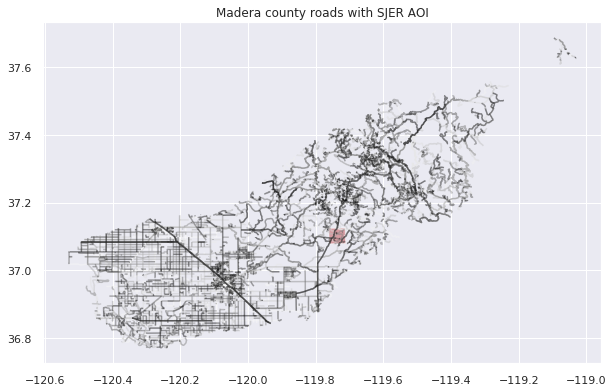

In [116]:
fig, ax = plt.subplots(figsize = (10,10))
madera_roads.plot(ax=ax, cmap='Greys', alpha=0.5)
sjer_aoi_wgs84.plot(ax=ax, color='r', markersize=20, alpha=0.5)
ax.set_title('Madera county roads with SJER AOI')

## Optional work - drawing map of USA

{'init': 'epsg:4326'} (1, 2) Index(['NAME', 'geometry'], dtype='object')
{'init': 'epsg:4326'} (58, 11) Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'region', 'geometry'],
      dtype='object')
[-124.725839   24.498131  -66.949895   49.384358]
[-119.76262834   37.07990136 -119.71268568   37.12656698]


[(36, 50), (-125, -116)]

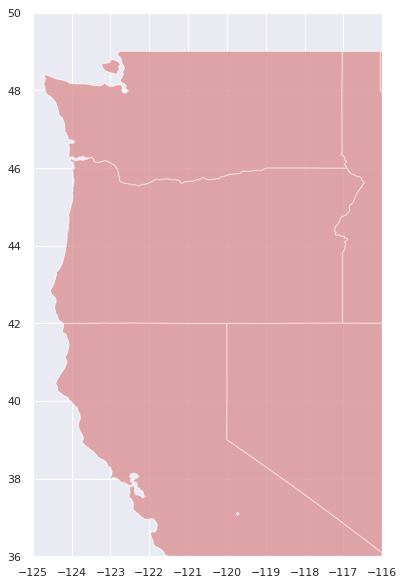

In [137]:
usa = gpd.read_file('data/tut/usa/usa-boundary-dissolved.shp')
usa_state_boundary = gpd.read_file('data/tut/usa/usa-states-census-2014.shp')
print(usa.crs, usa.shape, usa.columns)
print(usa_state_boundary.crs, usa_state_boundary.shape, usa_state_boundary.columns)
print(usa.total_bounds)
print(sjer_aoi_4326.total_bounds)
sjer_aoi_4326 = sjer_aoi.to_crs({'init':'epsg:4326'})
fig, ax = plt.subplots(figsize = (10, 10))
usa.plot(ax=ax, cmap='Greys', alpha=0.8)
usa_state_boundary.plot(ax=ax, color='r', alpha=0.5)
sjer_aoi_4326.plot(ax=ax, color='blue')
ax.set(xlim=[-125, -116], ylim=[36, 50])

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'region', 'geometry'],
      dtype='object')


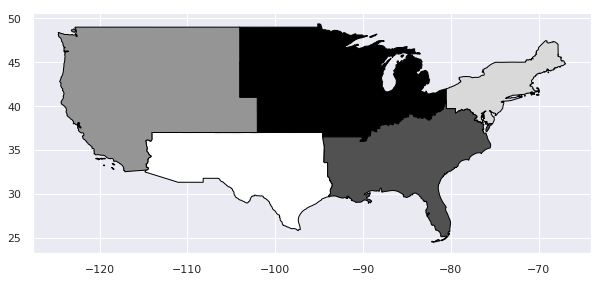

In [165]:
print(usa_state_boundary.columns)
fig, ax = plt.subplots(figsize = (10, 10))
usa_state_boundary[['region', 'geometry', 'ALAND', 'AWATER']].dissolve(by='region', aggfunc={'ALAND':'mean', 'AWATER':'max'}).reset_index().plot(column='AWATER', ax=ax, scheme='Quantiles', edgecolor='black', cmap='Greys')
# usa_state_boundary.plot(column='region')

# Lesson 7: Cropping raster data in python

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3292, 'height': 1516, 'count': 1, 'crs': CRS({'init': 'epsg:32611'}), 'transform': (296906.0, 1.0, 0.0, 4101554.0, 0.0, -1.0), 'affine': Affine(1.0, 0.0, 296906.0,
       0.0, -1.0, 4101554.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


Text(0.5,1,'CHM model')

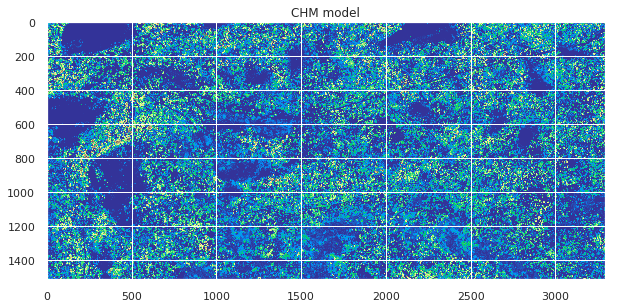

In [180]:
fig, ax = plt.subplots(figsize = (10, 10))
chm_profile = dsm_meta
print(chm_profile)
extent = dtm_extent
show(chm, ax=ax, cmap='terrain')
ax.set_title('CHM model')

crop extent crs:  {'init': 'epsg:32611'}
lidar crs:  CRS({'init': 'epsg:32611'})


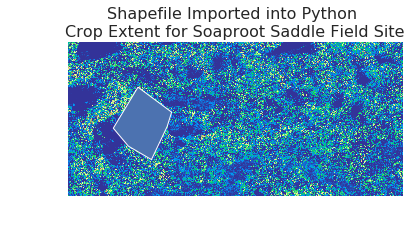

In [185]:
crop_extent_soap = gpd.read_file('data/tut/california/neon-soap-site/vector_data/SOAP_crop2.shp')
print('crop extent crs: ', crop_extent_soap.crs)
print('lidar crs: ', chm_profile['crs'])
# plot the data
fig, ax = plt.subplots(figsize = (6, 6))
crop_extent_soap.plot(ax=ax)
ax.imshow(chm, cmap='terrain', extent = extent)
ax.set_title("Shapefile Imported into Python \nCrop Extent for Soaproot Saddle Field Site", 
             fontsize = 16)
ax.set_axis_off();

## Now let's crop the data
* Mask it
* Change metadata (very imp!)

{'type': 'Polygon', 'coordinates': (((297592.4409283436, 4101114.950074496), (297923.28566590196, 4100869.1796980244), (297879.1730342275, 4100727.3890962135), (297724.7788233669, 4100402.84616318), (297497.91386046977, 4100535.1840582034), (297349.8214541342, 4100711.6345849014), (297592.4409283436, 4101114.950074496)),)}
[297349.0, 298062.0, 4101114.0, 4101115.0] [ 297349.82145413 4100402.84616318  297923.2856659  4101114.9500745 ]


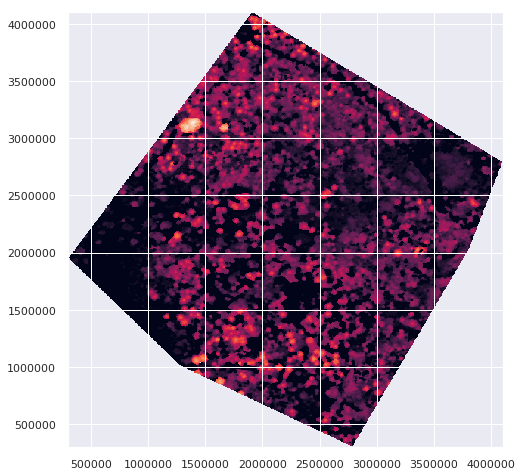

In [215]:
from rasterio.mask import mask
from shapely.geometry import mapping
soap_chm_path = 'data/tut/california/neon-soap-site/2013/lidar/SOAP_lidarCHM.tif'
with rio.open(soap_chm_path) as src:
    extent_geojson = mapping(crop_extent_soap['geometry'][0])
    print(extent_geojson)
    lidar_chm_crop, crop_affine = mask(src, 
                                   shapes=[extent_geojson], 
                                   crop=True)
    # metadata for writing or exporting the data
    soap_lidar_meta = src.meta.copy()
    
# Update the metadata to have the new shape (x and y and affine information)
soap_lidar_meta.update({"driver": "GTiff",
                 "height": lidar_chm_crop.shape[0],
                 "width": lidar_chm_crop.shape[1],
                 "transform": crop_affine})
# generate an extent for the newly cropped object for plotting
cr_ext = rio.transform.array_bounds(soap_lidar_meta['height'], 
                                            soap_lidar_meta['width'], 
                                            soap_lidar_meta['transform'])
bound_order = [0,2,1,3]
cr_extent = [cr_ext[b] for b in bound_order]
print(cr_extent, crop_extent_soap.total_bounds)
# mask the nodata and plot the newly cropped raster layer
lidar_chm_crop_ma = np.ma.masked_equal(lidar_chm_crop[0], -9999.0) 
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(lidar_chm_crop_ma, extent = cr_ext)
# Save to disk so you can use the file later.
# path_out = "data/outputs/soap_lidar_chm_crop.tif"
# with rio.open(path_out, 'w', **soap_lidar_meta) as ff:
#     ff.write(lidar_chm_crop[0], 1)

In [217]:
print(cr_ext, crop_extent_soap.total_bounds)

(297349.0, 4101114.0, 298062.0, 4101115.0) [ 297349.82145413 4100402.84616318  297923.2856659  4101114.9500745 ]


In [207]:
cr_extent

[297349.0, 298062.0, 4101114.0, 4101115.0]